In [3]:
pip install pymorphy2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
import pymorphy2
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DL project

Mounted at /content/drive
/content/drive/My Drive/DL project


# Data preparation

In [6]:
data = pd.read_csv('news.csv')
data.head()

,source,title,text,publication_date,rubric,subrubric,tags
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN
2,lenta.ru,Объяснена опасность однообразного питания,Российский врач-диетолог Римма Мойсенко объясн...,2020-08-31T20:07:00+03:00,Из жизни,Еда,NaN
3,lenta.ru,«Предохраняться? А зачем?»,В 2019 году телеканал «Ю» запустил адаптацию з...,2020-08-30T00:04:00+03:00,Интернет и СМИ,ТВ и радио,NaN
4,lenta.ru,Ефремов систематически употреблял наркотики,Актер Михаил Ефремов систематически употребл...,2020-08-31T18:27:00+03:00,Культура,Кино,NaN


In [8]:
data.query('rubric == "Спорт"').head()

,source,title,text,publication_date,rubric,subrubric,tags
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN
22,lenta.ru,Хоккейному клубу ЦСКА вручили золотые медали и...,В Москве в Зале хоккейной славы состоялась тор...,2020-08-31T18:06:53+03:00,Спорт,Хоккей,NaN
32,lenta.ru,Соболев высказался о конфликте с Дзюбой,Нападающий московского «Спартака» Александр...,2020-08-31T15:36:00+03:00,Спорт,Футбол,NaN
38,lenta.ru,ЦСКА разгромил «Ахмат» в матче РПЛ,Московский ЦСКА разгромил грозненский «Ахмат...,2020-08-30T21:12:33+03:00,Спорт,Футбол,NaN
43,lenta.ru,«Локомотив» объявил о переходе Миранчука в «Ат...,Московский «Локомотив» объявил о переходе по...,2020-08-30T18:26:00+03:00,Спорт,Футбол,NaN


In [9]:
rub = data.groupby('rubric').agg({'text' : 'count'}).sort_values('text', ascending=False)
rub.tail()

,text
rubric,
Путешествия,183
Ценности,141
Дом,123
Нацпроекты,53
69-я параллель,27


In [10]:
subset_1 = rub.loc[(rub['text'] > 30)]
subset_1.tail()

,text
rubric,
Из жизни,197
Путешествия,183
Ценности,141
Дом,123
Нацпроекты,53


In [11]:
data = data[data['rubric'].isin(subset_1.index)]
data.shape

(4476, 7)

In [12]:
sub = data.groupby('subrubric').agg({'text' : 'count'}).sort_values('text', ascending=False)
sub.tail()

,text
subrubric,
Движение,2
Офис,2
Софт,1
Нацпроекты,1
Реклама,1


In [13]:
subset_2 = sub.loc[(sub['text'] > 30)]
subset_2.tail()

,text
subrubric,
Криминал,41
Гаджеты,39
Летние виды,38
Деньги,38
Coцсети,37


In [14]:
subset_2.index

Index(['Общество', 'Политика', 'Госэкономика', 'Происшествия', 'Украина',
       'Белоруссия', 'Футбол', 'Следствие и суд', 'Бокс и ММА', 'Кино',
       'Английский футбол', 'ТВ и радио', 'Люди', 'Мир', 'Музыка',
       'Зимние виды', 'Наука', 'Интернет', 'Рынки', 'Явления', 'Квартира',
       'Конфликты', 'Россия', 'Все', 'Полиция и спецслужбы', 'Город', 'Звери',
       'Оружие', 'Деловой климат', 'Внешний вид', 'Криминал', 'Гаджеты',
       'Летние виды', 'Деньги', 'Coцсети'],
      dtype='object', name='subrubric')

In [15]:
data = data[data['subrubric'].isin(subset_2.index)]
data.shape

(4041, 7)

In [16]:
data.isnull().sum()

source                 0
title                  0
text                   0
publication_date       0
rubric                 0
subrubric              0
tags                4041
dtype: int64

In [ ]:
data.rubric.value_counts()

Россия               873
Мир                  714
Спорт                456
Бывший СССР          358
Экономика            354
Силовые структуры    210
Интернет и СМИ       186
Культура             180
Путешествия          169
Из жизни             159
Наука и техника      150
Ценности             104
Дом                  103
Нацпроекты            25
Name: rubric, dtype: int64

In [ ]:
data.subrubric.value_counts()

Общество                771
Политика                634
Госэкономика            206
Происшествия            202
Украина                 199
Белоруссия              159
Футбол                  145
Следствие и суд         118
Бокс и ММА              115
Кино                    104
Английский футбол        86
ТВ и радио               85
Люди                     80
Мир                      75
Музыка                   72
Зимние виды              70
Наука                    68
Интернет                 63
Рынки                    62
Явления                  58
Квартира                 57
Конфликты                53
Россия                   51
Все                      48
Город                    46
Полиция и спецслужбы     46
Звери                    45
Деловой климат           44
Оружие                   44
Внешний вид              42
Криминал                 41
Гаджеты                  39
Деньги                   38
Летние виды              38
Coцсети                  37
Name: subrubric, dty

In [17]:
data = data[['text', 'rubric', 'subrubric']]
data.head()

,text,rubric,subrubric
0,В 1930-е годы Советский Союз охватила лихорадк...,Экономика,Госэкономика
1,Олимпийская чемпионка по фигурному катанию Ал...,Спорт,Зимние виды
3,В 2019 году телеканал «Ю» запустил адаптацию з...,Интернет и СМИ,ТВ и радио
4,Актер Михаил Ефремов систематически употребл...,Культура,Кино
7,Недавно министр обороны Белоруссии Виктор Хре...,Бывший СССР,Белоруссия


In [18]:
len(data.rubric.value_counts()), len(data.subrubric.value_counts())

(14, 35)

In [19]:
data.shape

(4041, 3)

In [ ]:
data.text[100]

'Силовики разогнали протестующих у Дома правительства в центре столицы Белоруссии. Об этом сообщает TUT.by. По информации портала, часть демонстрантов оказалась заблокирована в Красном костеле. При этом некоторые из протестующих сами забежали в храм, после этого омоновцы затолкали внутрь тех, кто просто стоял на крыльце, включая журналистов. Всего на площади Независимости находились несколько сотен человек. Они принесли с собой бело-красно-белые флаги и пели песни. Силовики предупредили о незаконности акции и призвали разойтись. Однако люди остались на площади и продолжили митинг, после этого начались задержания. В Белоруссии третью неделю продолжаются массовые акции протеста из-за результатов прошедших 9 августа президентских выборов, на которых, по официальным данным, действующий глава государства  Александр Лукашенко  набрал 80 процентов голосов. Первые дни акции жестко разгонялись, в ходе чего пострадали сотни людей. Оппозиционный кандидат  Светлана Тихановская  находится в Литве.'

# Text preprocessing and analysis

In [20]:
def text_cleaner(text, lemm=True):
    """
    Преобразование исходного текста
    :param text: входной текст
    :param lemm: лемматизация
    :return: обработанный текст
    """
    new_string = text.lower()  # lower register
    new_string = re.sub("[^а-яА-Я]", " ", new_string)  # delete all except russian
    # removing stop words
    tokens = [w for w in new_string.split() if not w in stop_words]
    # removing short words
    words = [w for w in tokens if len(w) >= 3]
    # lemmatization
    if lemm:
        words = [morph.parse(w)[0].normal_form for w in words]

    return ' '.join(words).strip()

In [21]:
text_cleaner(data.text[100])

'силовик разогнать протестовать дом правительство центр столица белоруссия сообщать информация портал часть демонстрант оказаться заблокировать красный костёл некоторый протестовать сам забежать храм омоновец затолкать внутрь тот просто стоять крыльцо включая журналист площадь независимость находиться несколько сотня человек принести себя белый красный белые флаг петь песня силовик предупредить незаконность акция призвать разойтись однако человек остаться площадь продолжить митинг начаться задержание белоруссия третий неделя продолжаться массовый акция протест результат прошедшее август президентский выборы который официальный данные действовать глава государство александр лукашенко набрать процент голос первый день акция жёстко разгоняться ход пострадать сотня человек оппозиционный кандидат светлана тихановский находиться литва'

In [22]:
X = [text_cleaner(i) for i in tqdm(data.text)]

100%|██████████| 4041/4041 [01:59<00:00, 33.83it/s]


In [23]:
X[:5]

['год советский союз охватить лихорадка десятилетие бурный индустриализация повсюду греметь сообщение новый трудовой подвиг простой народ ради построение коммунизм светлый будущее первый стать шахтёр донбасс алексей стаханов год назад установить рекорд добыча уголь смена следующий утро проснуться знаменитый весь мир одаривать квартира машина возить союз стать любимец сталин однако итог выдержать слава спиться фамилия стаханов который дать название движение трудовик превратиться нарицательный продолжить существовать отдельно живой витрина коммунизм материал лента история легенда советский труд начаться шахта центральный ирмин донбасс год советский власть запустить второй пятилетка активно проводить политика ускоренный индустриализация пытаться завет владимир ленин догнать перегнать развитой капиталистический страна который безнадёжно отстать экономический план распад российский империя однако препятствие путь низкий производительность труд советский рабочий например угольный промышленно

In [24]:
# Dictionary of all words from corpus with their counts.
words_counts = {}

for text in X:   
    for word in text.split():
        if word in words_counts:
            words_counts[word] += 1
        else:
            words_counts[word] = 1

In [25]:
len(words_counts)

28401

In [26]:
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5]

In [27]:
most_common_words

[('который', 4456),
 ('год', 4430),
 ('россия', 3426),
 ('коронавирус', 2828),
 ('человек', 2790)]

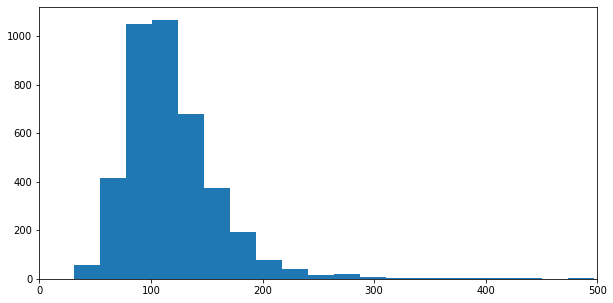

In [28]:
text_word_count = [len(i.split()) for i in X]

plt.figure(figsize=[10,5])
plt.hist(text_word_count, 100)
plt.xlim([0,500])

plt.show()

In [29]:
np.mean(text_word_count)

125.07300173224449

In [30]:
cnt=0
for i in X:
    if(len(i.split())<=200):
        cnt=cnt+1

print(cnt/len(X))

0.9537243256619649


# Rubric classification (14 categories)

## LogisticRegression

### Data vectorization

Предсказываемую рубрику сохраняем в исходном виде в переменную y:

In [55]:
y = data.rubric

Для текстов используем векторизацию с помощью tf-idf:

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X)

X_tfidf = tfidf_vectorizer.transform(X)

In [57]:
X_tfidf

<4041x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 364834 stored elements in Compressed Sparse Row format>

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

In [59]:
y_train.reset_index(inplace=True, drop=True)
y_train

0          Интернет и СМИ
1                  Россия
2          Интернет и СМИ
3         Наука и техника
4         Наука и техника
              ...        
3631                Спорт
3632                  Мир
3633             Культура
3634                Спорт
3635    Силовые структуры
Name: rubric, Length: 3636, dtype: object

### Model

In [60]:
#функция для оценки ошибки модели(LogisticRegression) с помощью кроссвалидации данных(k-fold):
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


def kfold(X, y):

    model = LogisticRegression(solver='sag',
                               penalty='l2',
                               random_state = 42)
    
    kf = KFold(n_splits = 3, random_state = 42, shuffle = True)
    f1_list = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        f1 = f1_score(y_test, predict, average='micro')
        print(i, f1)
        f1_list.append(f1)
    
    return np.mean(f1_list)

In [61]:
 kfold(X_train, y_train)

0 0.7508250825082509
1 0.7277227722772277
2 0.7277227722772277


0.7354235423542356

In [62]:
lr = LogisticRegression(solver='saga',
                        penalty='l2',
                        random_state = 42)


lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

In [63]:
def print_evaluation_scores(y_val, predicted):
    print('accuracy ' + str(accuracy_score(y_val, predicted)), '\n',
          'f1 ' + str(f1_score(y_val, predicted, average='micro')))

print_evaluation_scores(y_test, predicted)

accuracy 0.7975308641975308 
 f1 0.7975308641975308


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_test, y_test_predicted, classes=y_test.unique(),
                      #title='Confusion matrix, without normalization')


#plt.show()

## Feed forward neural network

### Data vectorization

In [230]:
import tensorflow as tf
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, BatchNormalization
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.models import load_model

In [ ]:
@tf.function(experimental_relax_shapes=True)
def predict(x):
     return model.predict(x)

Бинаризуем метки с помощью one_hot encoding:

In [65]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_one_hot = lb.fit_transform(y)

In [66]:
y_one_hot[:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Векторизуем тексты с помощью библиотеки Tokenizer:

In [185]:
# vocab size
max_seq_len = 200

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index) + 1

X_vec = tokenizer.texts_to_sequences(X)
X_vec = pad_sequences(X_vec, padding='post', maxlen=max_seq_len)

In [186]:
vocab_size

28402

In [187]:
len(X_vec[100])

200

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_one_hot, test_size=0.1, random_state=42)

In [189]:
len(X_train), len(y_train)

(3636, 3636)

In [190]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


opts = [optimizers.Adagrad(learning_rate=0.01),
        optimizers.Adam(learning_rate=0.001),
        optimizers.Adamax(learning_rate=0.001),
        keras.optimizers.Nadam(learning_rate=0.001)]

### Model

In [191]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))             
model.add(Dense(14, activation='softmax'))


model.compile(optimizer=opts[1],
             loss='categorical_crossentropy',
             metrics=[get_f1])


print(model.summary())      # вывод структуры НС в консоль

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 100)          2840200   
_________________________________________________________________
flatten_16 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 14)                1806      
Total params: 5,402,134
Trainable params: 5,402,134
Non-trainable params: 0
_________________________________________________________________
None


In [192]:
model.fit(X_train, y_train, batch_size=30, epochs=50, 
          validation_split=0.2, 
          callbacks=EarlyStopping(monitor='val_get_f1', mode='max', patience = 2))

Epoch 1/50
97/97 [==============================] - 7s 64ms/step - loss: 2.4486 - get_f1: 9.3326e-04 - val_loss: 2.1353 - val_get_f1: 0.0026
Epoch 2/50
97/97 [==============================] - 6s 63ms/step - loss: 1.5545 - get_f1: 0.3224 - val_loss: 1.1492 - val_get_f1: 0.6241
Epoch 3/50
97/97 [==============================] - 6s 61ms/step - loss: 0.2701 - get_f1: 0.9250 - val_loss: 0.9467 - val_get_f1: 0.7045
Epoch 4/50
97/97 [==============================] - 6s 61ms/step - loss: 0.0457 - get_f1: 0.9961 - val_loss: 0.9018 - val_get_f1: 0.7149
Epoch 5/50
97/97 [==============================] - 6s 60ms/step - loss: 0.0257 - get_f1: 0.9970 - val_loss: 0.9707 - val_get_f1: 0.7094
Epoch 6/50
97/97 [==============================] - 6s 63ms/step - loss: 0.0140 - get_f1: 0.9988 - val_loss: 0.9477 - val_get_f1: 0.7175
Epoch 7/50
97/97 [==============================] - 6s 62ms/step - loss: 0.0163 - get_f1: 0.9977 - val_loss: 0.9739 - val_get_f1: 0.7188
Epoch 8/50
97/97 [===================

In [194]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 6ms/step - loss: 0.8681 - get_f1: 0.7664


[0.8681237697601318, 0.7664445638656616]

In [195]:
model.save('model_rubric.h5', include_optimizer=True)

dependencies = {
    'get_f1': get_f1
}

model_rubric = load_model('model_rubric.h5', custom_objects=dependencies)

model_rubric.compile(optimizer=opts[1],
             loss='categorical_crossentropy',
             metrics=[get_f1])

### Inference

In [182]:
def inference(text, model, binarizer):

  text = text_cleaner(text)

  text = tokenizer.texts_to_sequences([text])
  text = pad_sequences(text, 200, padding='post')

  pred = model.predict(text)
  pred[pred>=0.5] = 1
  pred[pred<0.5] = 0
  pred = binarizer.inverse_transform(pred)
  return ' '.join(pred)


In [183]:
data.text[95]

'В сети появилось полное видео, на котором запечатлена поездка президента России  Владимира Путина  по новой мегатрассе «Таврида» в Крыму. Ролик опубликован в четверг, 27 августа, в  Telegram -канале «Крым 24». На кадрах можно увидеть, как глава государства пристегивается и обсуждает новую дорогу с главным технологом генерального подрядчика строительства дороги АО «ВАД»  Андреем Волковым , который сидит рядом с ним. По словам Путина, перед тем как проехать по «Тавриде» за рулем автомобиля, он смог осмотреть почти всю трассу с воздуха. «Впечатляет. Красиво. Современный объект, по-настоящему современный», — заявил президент. Он отметил, что для удобства туристов с трассы необходимо сделать съезды непосредственно к побережью. Ранее  сообщалось , что автомобиль Aurus, на котором Путин прокатился по новой дороге, имел номер с крымским кодом 82. «Таврида» является ключевой автодорогой полуострова, она пройдет от Крымского моста в Керчи до Севастополя. Это вдвое сократит время передвижения по

In [244]:
text = 'силовик разогнать протестовать дом правительство центр столица белоруссия сообщать информация портал часть демонстрант оказаться заблокировать красный костёл некоторый протестовать сам забежать храм омоновец затолкать внутрь тот просто стоять крыльцо включая журналист площадь независимость находиться несколько сотня человек принести себя белый красный белые флаг петь песня силовик предупредить незаконность акция призвать разойтись однако человек остаться площадь продолжить митинг начаться задержание белоруссия третий неделя продолжаться массовый акция протест результат прошедшее август президентский выборы который официальный данные действовать глава государство александр лукашенко набрать процент голос первый день акция жёстко разгоняться ход пострадать сотня человек оппозиционный кандидат светлана тихановский находиться литвае'

result = inference('Футболисты выиграли чемпионат англии', model_rubric, lb)
result

'Спорт'

# Subrubric classification (35 categories)

## Feed forward neural network

### Data vectorization

In [199]:
y = data.subrubric

In [200]:
lb_2 = LabelBinarizer()
y_one_hot = lb_2.fit_transform(y)

In [201]:
len(y_one_hot[0])

35

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_one_hot, test_size=0.1, random_state=42)

### Model

In [209]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_len))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5))               
model_2.add(Dense(35, activation='softmax'))


model_2.compile(optimizer=opts[1],
             loss='categorical_crossentropy',
             metrics=[get_f1])


print(model_2.summary())      # вывод структуры НС в консоль

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 100)          2840200   
_________________________________________________________________
flatten_18 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               2560128   
_________________________________________________________________
dense_38 (Dense)             (None, 35)                4515      
Total params: 5,404,843
Trainable params: 5,404,843
Non-trainable params: 0
_________________________________________________________________
None


In [210]:
model_2.fit(X_train, y_train, batch_size=30, epochs=50, 
          validation_split=0.2, 
          callbacks=EarlyStopping(monitor='val_get_f1', mode='max', patience = 2))

Epoch 1/50
97/97 [==============================] - 7s 62ms/step - loss: 2.8840 - get_f1: 0.1235 - val_loss: 1.8414 - val_get_f1: 0.4789
Epoch 2/50
97/97 [==============================] - 6s 61ms/step - loss: 0.3739 - get_f1: 0.9032 - val_loss: 1.7105 - val_get_f1: 0.5346
Epoch 3/50
97/97 [==============================] - 6s 58ms/step - loss: 0.0145 - get_f1: 0.9980 - val_loss: 1.6880 - val_get_f1: 0.5405
Epoch 4/50
97/97 [==============================] - 6s 60ms/step - loss: 0.0098 - get_f1: 0.9978 - val_loss: 1.6820 - val_get_f1: 0.5509
Epoch 5/50
97/97 [==============================] - 6s 61ms/step - loss: 0.0076 - get_f1: 0.9981 - val_loss: 1.6883 - val_get_f1: 0.5557
Epoch 6/50
97/97 [==============================] - 6s 60ms/step - loss: 0.0072 - get_f1: 0.9985 - val_loss: 1.6934 - val_get_f1: 0.5557
Epoch 7/50
97/97 [==============================] - 6s 59ms/step - loss: 0.0054 - get_f1: 0.9987 - val_loss: 1.7028 - val_get_f1: 0.5542


In [222]:
model_subrubric.evaluate(X_test, y_test)

13/13 [==============================] - 0s 6ms/step - loss: 1.5182 - get_f1: 0.6130


[1.5585861206054688, 0.5775216817855835]

In [241]:
model_2.save('model_subrubric.h5', include_optimizer=False)

dependencies = {
    'get_f1': get_f1
}

model_subrubric = load_model('model_subrubric.h5', custom_objects=dependencies)

In [242]:
model_subrubric.compile(optimizer=opts[1],
                        loss='categorical_crossentropy',
                        metrics=[get_f1])

### Inference

In [ ]:
data.text[25]

'Житель Украины, страдающий психическим заболеванием, попытался пешком перейти государственную границу России. Об этом в понедельник, 31 августа,  сообщает  пресс-служба прокуратуры Брянской области. По данным пресс-службы, инцидент произошел в Климовском районе региона еще 17 февраля. 34-летнего мужчину около 13:00 задержали в тот момент, когда он шел в обход пунктов пропуска без разрешения на въезд в Россию с территории Украины. После задержания психбольного было возбуждено уголовное дело по части 1 статьи 322 («Пересечение Государственной границы России без действительных документов на право въезда в Россию») УК РФ с максимальным наказанием до двух лет лишения свободы. Расследование проводило региональное управление  ФСБ России . В настоящее время уголовное дело в отношении мужчины направлено для рассмотрения в Климовский районный суд.  Прокуратура  намерена просить суд о применении к нарушителю границы принудительных мер медицинского характера. 31 июля  сообщалось , что на границе 

In [ ]:
data.subrubric[25]

'Следствие и суд'

In [237]:
result = inference('Житель Украины, страдающий психическим заболеванием, попытался пешком перейти государственную границу России. Об этом в понедельник, 31 августа,  сообщает  пресс-служба прокуратуры Брянской области. По данным пресс-службы, инцидент произошел в Климовском районе региона еще 17 февраля. 34-летнего мужчину около 13:00 задержали в тот момент, когда он шел в обход пунктов пропуска без разрешения на въезд в Россию с территории Украины. После задержания психбольного было возбуждено уголовное дело по части 1 статьи', model_subrubric, lb_2)
result

'Следствие и суд'